In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import uuid

warnings.filterwarnings("ignore")

In [12]:
RANGE_THRESHOLD = 0.6

def load_data_from_csv(minute_file):
    minute_data = pd.read_csv(minute_file)
    minute_data['Time'] = pd.to_datetime(minute_data['Time'])
    minute_data.set_index('Time', inplace=True)
    return minute_data

def preprocess_timeframe(df):
    local_df = df.copy()
    local_df = add_common_indicators(local_df)
    local_df = add_mean_reversion_indicators(local_df)
    return local_df

def add_common_indicators(df):
    df = df.dropna()
    data_length = len(df)
    sma_short = min(20, max(5, data_length // 4))
    sma_medium = min(50, max(10, data_length // 2))
    # Add moving averages
    df['sma20'] = df['Close'].rolling(window=sma_short).mean()
    df['sma50'] = df['Close'].rolling(window=sma_medium).mean()
    # Add Bollinger Bands
    df['bollinger_mid'] = df['sma20']
    df['bollinger_std'] = df['Close'].rolling(window=sma_short).std()
    df['bollinger_upper'] = df['bollinger_mid'] + 2 * df['bollinger_std']
    df['bollinger_lower'] = df['bollinger_mid'] - 2 * df['bollinger_std']
    # Add RSI
    rsi_window = min(14, max(5, data_length // 3))
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    rs = rs.replace([np.inf, -np.inf], np.nan).fillna(1)  # Handle division by zero
    df['rsi'] = 100 - (100 / (1 + rs))
    # Add ATR (Average True Range)
    atr_window = min(14, max(5, data_length // 3))
    tr1 = abs(df['High'] - df['Low'])
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr'] = tr.rolling(window=atr_window).mean()
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

def detect_range_boundaries(df, lookback):
    # Calculate based on historical highs and lows
    upper_boundary = df['High'].rolling(window=lookback).max()
    lower_boundary = df['Low'].rolling(window=lookback).min()
    return upper_boundary, lower_boundary

def add_mean_reversion_indicators(df):
    # Determine appropriate lookback based on timeframe
    data_length = len(df)
    lookback = min(60, max(5, data_length // 4))
    # Calculate adaptive mean
    df['mean'] = df['Close'].rolling(window=lookback).mean()
    # Detect range boundaries
    df['upper_range'], df['lower_range'] = detect_range_boundaries(df, lookback)
    # Calculate distance from mean and boundaries
    df['distance_from_mean'] = (df['Close'] - df['mean']) / df['mean'] * 100
    # Safely calculate distance from boundaries (as percentage of range)
    range_width = df['upper_range'] - df['lower_range']
    df['distance_from_upper'] = np.where(
        range_width > 0, 
        (df['upper_range'] - df['Close']) / range_width * 100,
        50  # Default value for undefined ranges
    )
    df['distance_from_lower'] = np.where(
        range_width > 0, 
        (df['Close'] - df['lower_range']) / range_width * 100,
        50  # Default value for undefined ranges
    )
    # Calculate range strength
    df['range_strength'] = calculate_range_strength(df, lookback)
    df['mean_reversion_probability'] = calculate_reversion_probability(df)
    df['is_range_market'] = df['range_strength'] > RANGE_THRESHOLD
    
    return df

def calculate_range_strength(df, lookback):
    price_direction = df['Close'].diff()
    direction_change = ((price_direction > 0) != (price_direction.shift() > 0)).rolling(window=lookback).sum()
    range_width = (df['upper_range'] - df['lower_range']) / df['mean']
    traversal = df['Close'].rolling(window=lookback).std() / range_width
    max_direction_changes = lookback - 1
    norm_direction_change = (direction_change / max_direction_changes).clip(0, 1)
    norm_range_width = (1 - range_width.clip(0, 0.2) / 0.2).clip(0, 1)
    norm_traversal = traversal.clip(0, 1)
    range_strength = (
        norm_direction_change * 0.4 +  # Frequency of oscillation
        norm_range_width * 0.3 +       # Narrowness of range
        norm_traversal * 0.3           # Coverage of range
    ).clip(0, 1)
    return range_strength

def calculate_reversion_probability(df):
    # Factor 1: Distance from mean (normalized)
    distance_factor = abs(df['distance_from_mean'] / 100).clip(0, 0.5) * 2
    # Factor 2: RSI extremes (higher probability when RSI is extreme)
    rsi = df['rsi'].fillna(50) 
    rsi_factor = np.where(rsi < 30, (30 - rsi) / 30, 
                        np.where(rsi > 70, (rsi - 70) / 30, 0))
    
    # Factor 3: Bollinger Band proximity
    bb_upper_dist = (df['Close'] - df['bollinger_upper']) / df['bollinger_std']
    bb_lower_dist = (df['bollinger_lower'] - df['Close']) / df['bollinger_std']
    bb_factor = np.where(bb_upper_dist > 0, bb_upper_dist, 
                       np.where(bb_lower_dist > 0, bb_lower_dist, 0)).clip(0, 1)
    # Factor 4: Range strength (higher probability in strong ranges)
    range_factor = df['range_strength']
    # Combine factors with weights
    probability = (
        distance_factor * 0.3 +
        rsi_factor * 0.2 + 
        bb_factor * 0.2 + 
        range_factor * 0.3
    ).clip(0, 1)
    return probability

def temporal_split(minute_data, split_date):
    split_date = pd.to_datetime(split_date).tz_localize('UTC')
    train_data = minute_data[minute_data.index < split_date].copy()
    test_data = minute_data[minute_data.index >= split_date].copy()
    return train_data, test_data

def get_data_at_timestamp(multi_timeframe_data, timestamp):
    result = {}
    for timeframe, df in multi_timeframe_data.items():
        # Get the last available row before or at the timestamp
        df_before = df[df.index <= timestamp]
        if not df_before.empty:
            result[timeframe] = df_before.iloc[-1]
        else:
            result[timeframe] = None
    return result

def prepare_multi_timeframe_data(minute_file, split_date="2022-01-01"):
    print(f"Loading data from CSV files...")
    minute_data = load_data_from_csv(minute_file)
    minute_data = preprocess_timeframe(minute_data)
    minute_data = round_df_revised(minute_data)
    # Split into training and testing sets
    print(f"Splitting data at {split_date}")
    train_data, test_data = temporal_split(minute_data, split_date)
    return train_data, test_data

def round_df_revised(df, decimals = 2):
    df_copy = df.copy()
    float_cols = df_copy.select_dtypes(include='float').columns
    df_copy[float_cols] = df_copy[float_cols].round(decimals)
    # capitalize the first letter of each column name
    # df_copy.columns = [col.capitalize() for col in df_copy.columns]
    return df_copy

# Example usage
if __name__ == "__main__":
    minute_file = "/Users/newuser/Projects/robust_algo_trader/data/gen_alpaca_data/CRM_M1_raw_data.csv"
    train_data, test_data = prepare_multi_timeframe_data(minute_file, split_date="2020-01-01")

Loading data from CSV files...
Splitting data at 2020-01-01


In [13]:
train_data

,Symbol,Open,High,Low,Close,Volume,Trade_count,Vwap,sma20,sma50,...,atr,mean,upper_range,lower_range,distance_from_mean,distance_from_upper,distance_from_lower,range_strength,mean_reversion_probability,is_range_market
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-04 13:01:00+00:00,CRM,76.73,76.73,76.57,76.57,876.0,9.0,76.64,76.38,76.10,...,0.29,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,False
2016-01-04 13:02:00+00:00,CRM,77.06,77.06,77.06,77.06,200.0,4.0,77.06,76.38,76.10,...,0.29,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,False
2016-01-04 13:05:00+00:00,CRM,76.22,76.22,76.22,76.22,100.0,1.0,76.22,76.38,76.10,...,0.29,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,False
2016-01-04 14:03:00+00:00,CRM,76.32,76.32,76.32,76.32,180.0,1.0,76.32,76.38,76.10,...,0.29,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,False
2016-01-04 14:04:00+00:00,CRM,76.36,76.36,76.36,76.36,350.0,2.0,76.36,76.38,76.10,...,0.29,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 21:10:00+00:00,CRM,161.72,161.72,161.72,161.72,27963.0,4.0,161.72,161.48,161.45,...,0.11,161.44,161.83,161.2,0.17,17.46,82.54,0.78,0.23,True
2019-12-31 21:11:00+00:00,CRM,161.72,161.72,161.72,161.72,527.0,5.0,161.72,161.49,161.46,...,0.11,161.44,161.83,161.2,0.17,17.46,82.54,0.77,0.24,True
2019-12-31 21:27:00+00:00,CRM,161.58,161.58,161.58,161.58,543.0,3.0,161.58,161.49,161.46,...,0.12,161.45,161.83,161.2,0.08,39.68,60.32,0.76,0.23,True


In [ ]:

# save the processed data to CSV files
train_data['minute'].to_csv('/Users/newuser/Projects/robust_algo_trader/data/gen_alpaca_data/CRM_M1_train_data.csv')
signals_df.to_csv('/Users/newuser/Projects/robust_algo_trader/data/gen_alpaca_data/CRM_M1_signals.csv')

In [ ]:
signals_df

In [14]:

class Position:
    def __init__(self, id, timestamp, action, price, stop_loss, target, entry_reason):
        self.id = id
        self.timestamp = timestamp
        self.action = action
        self.price = price
        self.stop_loss = stop_loss
        self.target = target
        self.entry_reason = entry_reason

class Signal:
    def __init__(self, timestamp, action, price, reason=''):
        self.timestamp = timestamp
        self.action = action
        self.price = price
        self.reason = reason
    
    def to_dict(self):
        return {
            'timestamp': self.timestamp,
            'action': self.action,
            'price': self.price,
            'reason': self.reason
        }


class MeanReversionStrategy:
    def __init__(self, params):
        self.entry_threshold_upper = params.get('entry_threshold_upper', 25)
        self.entry_threshold_lower = params.get('entry_threshold_lower', 25)
        self.exit_threshold_pct = params.get('exit_threshold_pct', 5)
        self.use_atr_stops = params.get('use_atr_stops', True)
        self.atr_multiplier = params.get('atr_multiplier', 2.0)
        self.stop_loss_range_factor = params.get('stop_loss_range_factor', 0.15)
        self.position_sizing_factor = params.get('position_sizing_factor', 1.0)
        self.max_position_size = params.get('max_position_size', 1.0)
        self.range_threshold = params.get('range_threshold', 0.5)
        self.positions = []
        self.last_action = "NOTHING"
    
    def generate_signals(self, data):
        signals = []
        for idx, row in data.iterrows():
            timestamp = idx
            current_price = float(row['Close'])
            
            signal = Signal(
                timestamp=timestamp,
                action="NOTHING",
                price=current_price,
                reason="default_state"
            )
            
            if pd.isna(row['mean']) or pd.isna(row['upper_range']) or pd.isna(row['lower_range']):
                signal.reason = "missing_data"
                signals.append(signal)
                continue
            
            if self.positions:
                position = self.positions[0]
                
                exit_reason = self._check_exit_conditions(row, position)
                if exit_reason:
                    signal.action = "CLOSE"
                    signal.reason = exit_reason
                    self.positions = []
                    self.last_action = "CLOSE"
                else:
                    signal.action = "HOLD"
                    signal.reason = "holding_position"
                    self.last_action = "HOLD"
                
                signals.append(signal)
                continue
            
            is_range_market = self._is_in_range_market(row)
            if not is_range_market:
                signal.reason = "not_range_market"
                signals.append(signal)
                continue
            
            entry_action = self._check_entry_conditions(row)
            if entry_action:
                signal.action = entry_action
                signal.reason = "long_mean_reversion" if entry_action == "BUY" else "short_mean_reversion"
                
                self._add_position(timestamp, current_price, row, entry_action)
                self.last_action = entry_action
            else:
                signal.reason = "no_entry_condition"
            
            signals.append(signal)
        
        return signals
    
    def _is_in_range_market(self, row):
        if 'is_range_market' in row and not pd.isna(row['is_range_market']):
            return bool(row['is_range_market'])
        elif 'range_strength' in row and not pd.isna(row['range_strength']):
            return float(row['range_strength']) > self.range_threshold
        return False
    
    def _check_entry_conditions(self, row):
        distance_from_lower = float(row['distance_from_lower'])
        distance_from_upper = float(row['distance_from_upper'])
        
        mean_reversion_prob = 0.7
        if 'mean_reversion_probability' in row and not pd.isna(row['mean_reversion_probability']):
            mean_reversion_prob = float(row['mean_reversion_probability'])
        
        if mean_reversion_prob <= 0.5:
            return None
            
        if distance_from_lower < self.entry_threshold_lower:
            return "BUY"
        
        if distance_from_upper < self.entry_threshold_upper:
            return "SELL"
        
        return None
    
    def _check_exit_conditions(self, row, position):
        current_price = float(row['Close'])
        # Check stop loss first (risk management priority)
        if (position.action == 'BUY' and current_price <= position.stop_loss) or \
           (position.action == 'SELL' and current_price >= position.stop_loss):
            return 'stop_loss_hit'
        
        # Direction-aware target checking
        if position.action == 'BUY':
            # For BUY positions, price should rise toward or above mean
            if current_price >= position.target:
                return 'target_reached'
        else:  # SELL
            # For SELL positions, price should fall toward or below mean
            if current_price <= position.target:
                return 'target_reached'
        
        return None
    
    def _add_position(self, timestamp, price, row, action):
        range_width = 0.7 * float(row['upper_range'] - row['lower_range'])
        # if range_width < 0.2:
        #     return
        # range_width = np.clip(range_width, 2, 3)
        # atr_width = (float(row['atr']) * self.atr_multiplier)
        # range_width = np.clip(range_width, 1, 2)
        
        if action == "BUY":
            stop_loss = price - range_width
            take_profit = price + range_width
        else:  # SELL
            stop_loss = price + range_width
            take_profit = price - range_width

        # target = float(row['mean'])
        
        position = Position(
            id=str(uuid.uuid4()),
            timestamp=timestamp,
            action=action,
            price=price,
            stop_loss=stop_loss,
            target=take_profit,
            entry_reason='long_mean_reversion' if action == "BUY" else 'short_mean_reversion'
        )
        
        self.positions.append(position)
    
    def reset(self):
        self.positions = []
        self.last_action = "NOTHING"


def run_strategy(data, params=None):
    if params is None:
        params = {
            'entry_threshold_upper': 15,
            'entry_threshold_lower': 15,
            'exit_threshold_pct': 2,
            'use_atr_stops': True,
            'atr_multiplier': 2,
            'position_sizing_factor': 1.0,
            'max_position_size': 1.0,
            'range_threshold': 0.65
        }
    
    strategy = MeanReversionStrategy(params)
    signals = strategy.generate_signals(data)
    
    return signals, strategy

signals, strategy = run_strategy(train_data)
signal_dicts = [signal.to_dict() for signal in signals]
signals_df = pd.DataFrame(signal_dicts)
signals_df

,timestamp,action,price,reason
0,2016-01-04 13:01:00+00:00,NOTHING,76.57,missing_data
1,2016-01-04 13:02:00+00:00,NOTHING,77.06,missing_data
2,2016-01-04 13:05:00+00:00,NOTHING,76.22,missing_data
3,2016-01-04 14:03:00+00:00,NOTHING,76.32,missing_data
4,2016-01-04 14:04:00+00:00,NOTHING,76.36,missing_data
...,...,...,...,...
422048,2019-12-31 21:10:00+00:00,NOTHING,161.72,no_entry_condition
422049,2019-12-31 21:11:00+00:00,NOTHING,161.72,no_entry_condition
422050,2019-12-31 21:27:00+00:00,NOTHING,161.58,no_entry_condition
422051,2019-12-31 21:38:00+00:00,NOTHING,161.72,no_entry_condition


Performance Summary:
total_trades: 622
win_rate: 59.163987138263664
profit_factor: 1.6617658683108054
net_profit: 167.4400000000001
win_loss_ratio: 1.1469797025840884
avg_win: 1.1425543478260867
avg_loss: -0.9961417322834644
avg_trade: 0.26919614147909987

Total Trades: 622


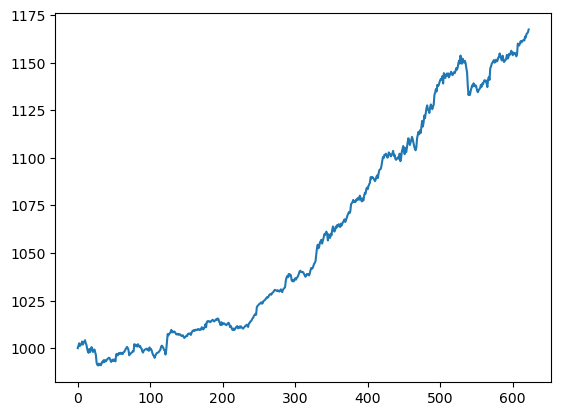

In [15]:

class SimpleBacktestEngine:
    def __init__(self, signals_df, params):
        self.signals_df = signals_df
        self.commission = 0.0  
        self.slippage = 0.0
        self.initial_capital = params.get('initial_capital', 100000)
        
        # Trading state variables
        self.trades = []
        self.current_capital = self.initial_capital
        self.current_position = None
        
        # For portfolio curve - only record significant points
        self.equity_curve = [{'timestamp': self.signals_df['timestamp'].min(), 
                             'equity': self.initial_capital}]
    
    def run_backtest(self):
        signals = self.signals_df.sort_values('timestamp').to_dict('records')
        
        # Process each signal
        for signal in signals:
            old_capital = self.current_capital
            self.process_signal(signal)
            
            # Only add to equity curve if capital changed
            if old_capital != self.current_capital:
                self.equity_curve.append({
                    'timestamp': signal['timestamp'],
                    'equity': self.current_capital
                })
            
        # Calculate performance metrics
        performance = self.calculate_performance()
        return performance, self.trades
    
    def process_signal(self, signal):
        """Process a single trading signal"""
        action = signal['action']
        price = signal['price']
        timestamp = signal['timestamp']
        reason = signal['reason']
        
        # Skip "NOTHING" and "HOLD" signals if no current position
        if action in ["NOTHING", "HOLD"] and not self.current_position:
            return
            
        # Process actionable signals
        if action == "BUY" and not self.current_position:
            # Create new position (no slippage)
            entry_price = price
            
            self.current_position = {
                'entry_time': timestamp,
                'entry_price': entry_price,
                'direction': 'LONG',
                'entry_reason': reason
            }
            
        elif action == "SELL" and not self.current_position:
            # Create new position (no slippage)
            entry_price = price
            
            self.current_position = {
                'entry_time': timestamp,
                'entry_price': entry_price,
                'direction': 'SHORT',
                'entry_reason': reason
            }
            
        elif action == "CLOSE" and self.current_position:
            # No slippage on exit
            exit_price = price
                
            # Calculate P&L directly with price difference
            if self.current_position['direction'] == 'LONG':
                points_pnl = exit_price - self.current_position['entry_price']
            else:  # SHORT
                points_pnl = self.current_position['entry_price'] - exit_price
            # P&L is just the price difference (no point value or position size)
            # Create completed trade record
            trade = {
                'entry_time': self.current_position['entry_time'],
                'entry_price': self.current_position['entry_price'],
                'exit_time': timestamp,
                'exit_price': exit_price,
                'direction': self.current_position['direction'],
                'points_pnl': points_pnl,
                'log(points_pnl)': np.log(abs(points_pnl)) if points_pnl != 0 else 0,
                'entry_reason': self.current_position['entry_reason'],
                'exit_reason': reason
            }
            self.trades.append(trade)
            self.current_capital += points_pnl
            self.current_position = None
    
    def calculate_performance(self):
        if not self.trades:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'profit_factor': 0,
                'net_profit': 0,
                'win_loss_ratio': 0,
                'avg_trade': 0
            }
        
        # Basic metrics
        total_trades = len(self.trades)
        winning_trades = [t for t in self.trades if t['points_pnl'] > 0]
        losing_trades = [t for t in self.trades if t['points_pnl'] < 0]
        win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
        
        gross_profit = sum(t['points_pnl'] for t in winning_trades) if winning_trades else 0
        gross_loss = abs(sum(t['points_pnl'] for t in losing_trades)) if losing_trades else 0
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
        net_profit = sum(t['points_pnl'] for t in self.trades)
        
        avg_win = gross_profit / len(winning_trades) if winning_trades else 0
        avg_loss = gross_loss / len(losing_trades) if losing_trades else 0
        win_loss_ratio = avg_win / abs(avg_loss) if avg_loss != 0 else float('inf')
        
        avg_trade = net_profit / total_trades
        
        return {
            'total_trades': total_trades,
            'win_rate': win_rate * 100,  # As percentage
            'profit_factor': profit_factor,
            'net_profit': net_profit,
            'win_loss_ratio': win_loss_ratio,
            'avg_win': avg_win,
            'avg_loss': -avg_loss,
            'avg_trade': avg_trade
        }
    
    def get_trade_summary(self):
        """Return a DataFrame with trade summary"""
        if not self.trades:
            return pd.DataFrame()
            
        return pd.DataFrame(self.trades)
    
    def get_equity_curve(self):
        """Return the equity curve as a DataFrame"""
        return pd.DataFrame(self.equity_curve)
    
    def plot_equity_curve(self):
        """Plot the equity curve"""
        equity_df = self.get_equity_curve()
        equity_df['equity'].plot()
        

# Setup parameters
params = {
    'commission': 0.0,     # $4.00 per round trip
    'slippage': 0.0,      # $10.00 (2 ticks)
    'initial_capital': 1000,
    'point_value': 20,     # $20 per point for NQ
    'position_size': 1     # Number of contracts
}

# Run backtest
backtest = SimpleBacktestEngine(signals_df, params)
performance, trades = backtest.run_backtest()

# Print performance summary
print("Performance Summary:")
for metric, value in performance.items():
    print(f"{metric}: {value}")

# Get trade details as DataFrame
trades_df = backtest.get_trade_summary()
print(f"\nTotal Trades: {len(trades_df)}")
# print(trades_df.head())

# Plot and show the equity curve
plt_fig = backtest.plot_equity_curve()

In [ ]:
min_data = train_data['minute']
min_data['Close'].plot()

In [17]:
trades_df

,entry_time,entry_price,exit_time,exit_price,direction,points_pnl,log(points_pnl),entry_reason,exit_reason
0,2016-01-05 14:30:00+00:00,76.72,2016-01-06 12:53:00+00:00,75.40,SHORT,1.32,0.277632,short_mean_reversion,target_reached
1,2016-01-06 13:31:00+00:00,75.32,2016-01-06 15:26:00+00:00,76.58,LONG,1.26,0.231112,long_mean_reversion,target_reached
2,2016-01-07 09:00:00+00:00,73.98,2016-01-08 20:49:00+00:00,72.57,LONG,-1.41,0.343590,long_mean_reversion,stop_loss_hit
3,2016-01-12 16:52:00+00:00,73.88,2016-01-12 17:18:00+00:00,73.39,SHORT,0.49,-0.713350,short_mean_reversion,target_reached
4,2016-01-12 19:04:00+00:00,72.78,2016-01-12 19:35:00+00:00,73.24,LONG,0.46,-0.776529,long_mean_reversion,target_reached
...,...,...,...,...,...,...,...,...,...
617,2019-12-19 20:57:00+00:00,162.23,2019-12-20 13:43:00+00:00,162.70,SHORT,-0.47,-0.755023,short_mean_reversion,stop_loss_hit
618,2019-12-20 14:29:00+00:00,163.95,2019-12-24 13:00:00+00:00,162.11,SHORT,1.84,0.609766,short_mean_reversion,target_reached
619,2019-12-26 18:02:00+00:00,163.31,2019-12-26 20:16:00+00:00,162.98,SHORT,0.33,-1.108663,short_mean_reversion,target_reached
620,2019-12-26 20:54:00+00:00,163.31,2019-12-26 21:04:00+00:00,162.69,SHORT,0.62,-0.478036,short_mean_reversion,target_reached
